In [1]:
## Parameters

# Tab settings
n_encoddings = 100          # Number of different drum encodings

# Audio settings
audio_sample_rate = 22050   # Keep at 22050Hz audio procesor will convert if higher
n_mels = 512                # Number of freq divisions in Mel-Spectrogram
hop_length = 512            # Audio samples averaged (used in the Mel-Spectrogram conversion) 

# Model settings
# The difference between size and skip allows some overlap between predictions, which then is resolved though voting.
window_skip = 16            # Time steps skipped between predictions 
window_size = 64            # Time steps fed to the model a the same time

mp3_directory = 'data\\raw\MP3'
gp5_directory = 'data\\raw\GP5'
processed_data_directory = 'data\\processed'

In [2]:
# Data load and processing
from src.song_manager import SongManager

manager = SongManager()
manager.load_dataset(mp3_directory, gp5_directory, n_mels=n_mels, skip=window_skip, window_size=window_size)
[X_i, Y_i] = manager.get_all_windows(window_size)
manager.save_processed_songs(processed_data_directory)

from sklearn.preprocessing import StandardScaler
# Create a scaler object
scaler = StandardScaler()

# Fit and transform the X data
X = scaler.fit_transform(X_i.reshape(-1, 1))
X = X.reshape(X_i.shape)

AttributeError: 'Song' object has no attribute 'audio_file_path'

In [42]:
import sys
import numpy as np
X = X.astype(np.float16)
Y = Y_i.astype(np.float16)

size_in_bytes = sys.getsizeof(X)
print(f"Memory size of variable: {size_in_bytes} bytes")

size_in_bytes = sys.getsizeof(Y)
print(f"Memory size of variable: {size_in_bytes} bytes")

Memory size of variable: 4980880 bytes
Memory size of variable: 972944 bytes


In [28]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)
print(tf.test.is_built_with_gpu_support())
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras import mixed_precision

policy_name = "mixed_float16"  # if you train on a GPU
policy = mixed_precision.Policy(policy_name)
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


Num GPUs Available:  1
2.10.0
True
Compute dtype: float16
Variable dtype: float32


In [29]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Activation, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import he_normal, glorot_normal

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window_size, 512)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(64,kernel_initializer=he_normal())) # Use Dense(1) for regression
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(64,kernel_initializer=he_normal())) # Use Dense(1) for regression
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_encoddings, dtype='float32', activation='sigmoid')))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64, 128)           328192    
                                                                 
 dropout_12 (Dropout)        (None, 64, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64, 64)            49408     
                                                                 
 dropout_13 (Dropout)        (None, 64, 64)            0         
                                                                 
 dense_9 (Dense)             (None, 64, 64)            4160      
                                                                 
 activation_6 (Activation)   (None, 64, 64)            0         
                                                                 
 dropout_14 (Dropout)        (None, 64, 64)           

Epoch 1/2000
2/2 [==============================] - 2s 448ms/step - loss: 0.6922 - accuracy: 0.0000e+00 - val_loss: 0.6604 - val_accuracy: 0.0000e+00
Epoch 2/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.6569 - accuracy: 0.0000e+00 - val_loss: 0.6292 - val_accuracy: 0.0000e+00
Epoch 3/2000
2/2 [==============================] - 0s 47ms/step - loss: 0.6223 - accuracy: 0.0000e+00 - val_loss: 0.5948 - val_accuracy: 0.0000e+00
Epoch 4/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.5836 - accuracy: 0.0000e+00 - val_loss: 0.5536 - val_accuracy: 0.0000e+00
Epoch 5/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.5397 - accuracy: 0.0000e+00 - val_loss: 0.5080 - val_accuracy: 0.0000e+00
Epoch 6/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.4924 - accuracy: 0.0000e+00 - val_loss: 0.4613 - val_accuracy: 0.0000e+00
Epoch 7/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.4407 - accuracy: 0.0000e+00 - 

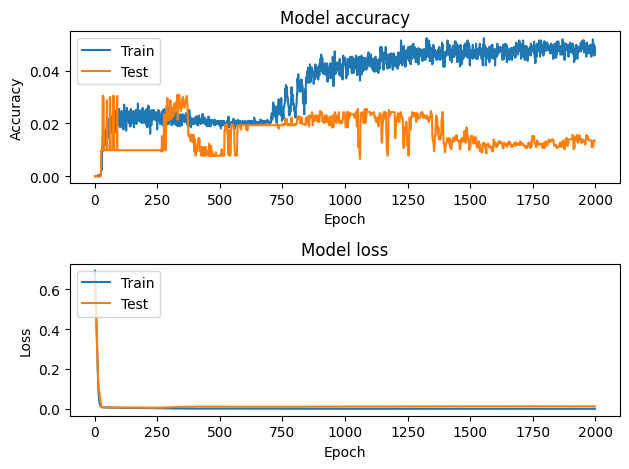

In [30]:
from src.visualization import visualize
from tensorflow.keras.models import load_model

#model = load_model('Models\DNET_V1.h5')
history = model.fit(X, Y, epochs=2000, batch_size=32, validation_split=0.5)
model.save('Models\DNET_V2.h5')  #creates a HDF5 file 'my_model.h5'
visualize.plot_training_history(history)

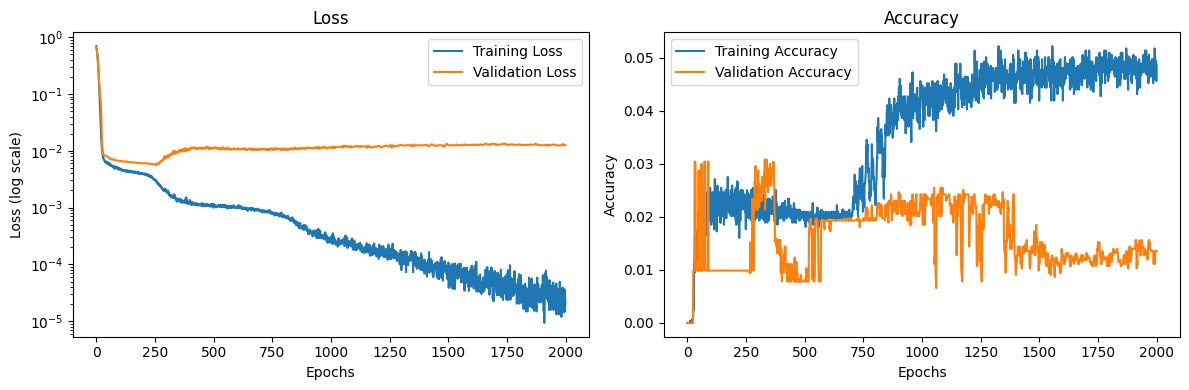

In [31]:
import matplotlib.pyplot as plt

def plot_training_history_logscale(history):
    plt.figure(figsize=(12, 4))
    
    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history_logscale(history)

In [32]:
# Generate predictions for all examples in the validation dataset
thresholded_predictions = visualize.generate_thresholded_predictions(model, X, 0.5)
from sklearn.metrics import accuracy_score
true_acuracy = accuracy_score(Y.flatten(),thresholded_predictions.flatten())
print(true_acuracy)


3/3 [==============================] - 1s 89ms/step
0.9995230263157895


In [33]:
from scipy import stats
import numpy as np
from scipy import stats

from scipy.stats import mode

def merge_windows(predictions, window_size, hop_size):
    """
    Merge overlapping windows of predictions into a single sequence using mode.
    
    Parameters:
    - predictions: 3D numpy array of shape (number of windows, window size, number of parameters).
    - window_size: The size of each window.
    - hop_size: The step size to move the window.
    
    Returns:
    - A single sequence of predictions.
    """

    num_windows, win_size, num_params = predictions.shape
    assert win_size == window_size, "Provided window size does not match the predictions shape."

    # Initialize a list to hold all predictions for each time step
    merged_predictions_list = [[[] for _ in range(num_params)] for _ in range((num_windows-1) * hop_size + window_size)]

    # Loop over each window of predictions
    for window_start in range(0, num_windows * hop_size, hop_size):
        window_end = window_start + window_size
        for i, timestep in enumerate(range(window_start, window_end)):
            for j in range(num_params):
                merged_predictions_list[timestep][j].append(predictions[int(window_start/hop_size)][i][j])

    # Determine mode for each timestep
    merged_predictions = np.zeros((len(merged_predictions_list), num_params))
    for i in range(len(merged_predictions_list)):
        for j in range(num_params):
            mode_val = mode(merged_predictions_list[i][j])[0]
            if np.isscalar(mode_val):
                merged_predictions[i][j] = mode_val
            else:
                merged_predictions[i][j] = mode_val[0]
    return merged_predictions

def merge_windows(predictions, window_size, hop_size):
    num_windows, win_size, num_params = predictions.shape
    assert win_size == window_size, "Provided window size does not match the predictions shape."

    # Define the size of the merged array
    merged_length = (num_windows-1) * hop_size + window_size
    merged_predictions = np.zeros((merged_length, num_params))

    # Create an overlap counter
    overlap_counter = np.zeros((merged_length, num_params))

    # Accumulate predictions and overlap count
    for window_start in range(0, num_windows * hop_size, hop_size):
        window_end = window_start + window_size
        merged_predictions[window_start:window_end] += predictions[int(window_start/hop_size)]
        overlap_counter[window_start:window_end] += 1

    # Calculate mode: Since you likely have binary values, you can determine mode by checking if the sum is > 0.5 * overlap_counter
    merged_predictions = np.where(merged_predictions > 0.5 * overlap_counter, 1, 0)

    return merged_predictions

# Usage:
merged_predictions = merge_windows(thresholded_predictions, window_size, window_skip)
merged_real_tabs = merge_windows(Y, window_size, window_skip)
merged_x = []

for song in manager.songs:
    merged_x.append(song.audio_processor.audio_data.T)

# Convert list of arrays to a single concatenated numpy array
merged_X = np.concatenate(merged_x, axis=0)


In [34]:
# Reverse the dictionary

mapping = {0: -1}
for idx, num in enumerate(range(29, 128)):
    mapping[num] = idx


reverse_dict = {v: k for k, v in mapping.items()}

def one_hot_to_encoding(one_hot_prediction, reverse_dict):
    hit_indices = np.argwhere(one_hot_prediction > 0)
    # Create an array with -1 for no hit
    encoding = np.full((one_hot_prediction.shape[0], 4), -1)
    
    # For each time step, fill in the hit values (up to 4)
    for t in range(one_hot_prediction.shape[0]):
        hits = hit_indices[hit_indices[:,0] == t]
        for i in range(len(hits)):
            hits[i, 1] = reverse_dict[hits[i, 1]]
        encoding[t,:len(hits)] = hits[:,1] # Use the dictionary to map to original encoding values
    
    return encoding

# Transform prediction
Y_pred_encoding = one_hot_to_encoding(merged_predictions, reverse_dict)
Y_pred_encoding = np.where(Y_pred_encoding == -1, 0, Y_pred_encoding)


Y_real = one_hot_to_encoding(merged_real_tabs, reverse_dict)
Y_real = np.where(Y_real == -1, 0, Y_real)

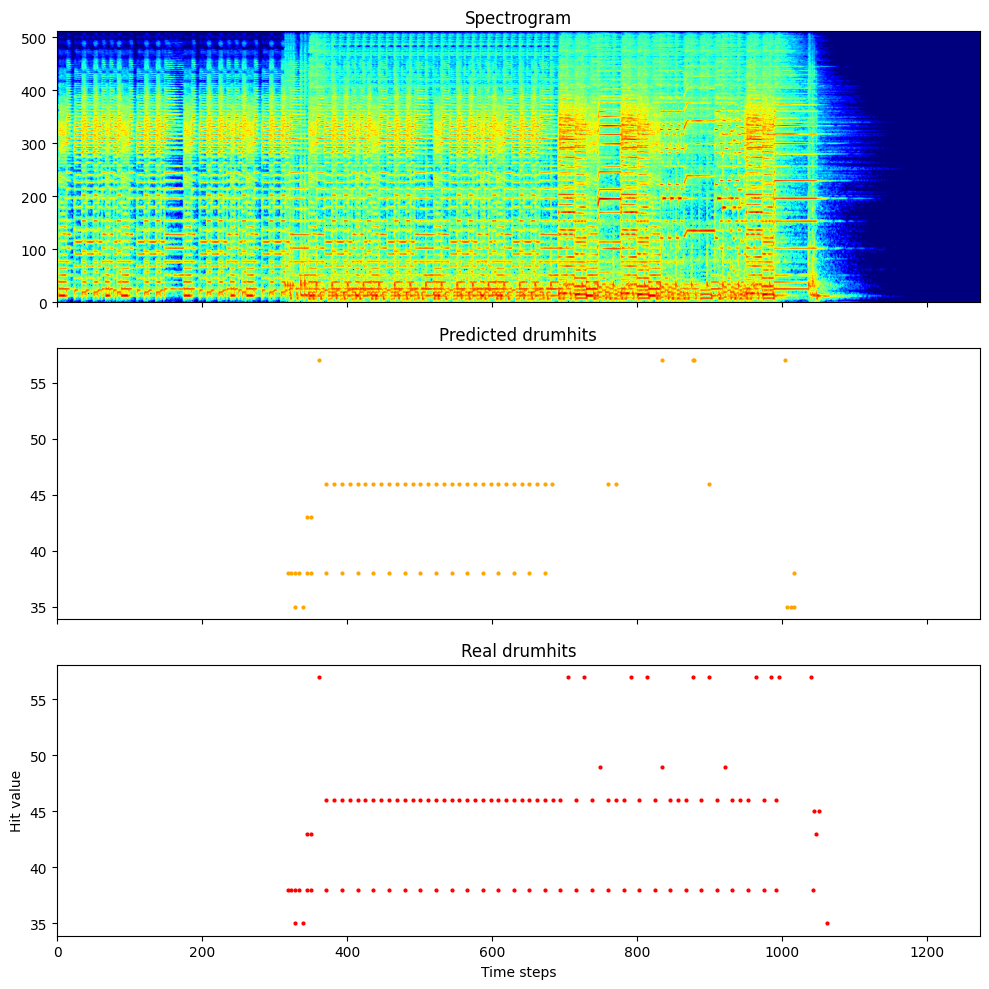

In [35]:
import matplotlib.pyplot as plt
import librosa
# Assuming the spectrogram is stored in a variable called "spectrogram"
# And the one-hot predictions are stored in a variable called "predictions"

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

# Plotting the spectrogram
ax[0].imshow(merged_X.T, aspect='auto', cmap='jet', origin='lower')
ax[0].set_title('Spectrogram')

# Plotting the predicted drumhits
data = Y_pred_encoding  # Dummy data
for i in range(4):
    # Find where data is not 0
    hits = data[:, i] != 0
    
    ax[1].plot(np.arange(len(data))[hits], data[hits, i], marker='o', linestyle='', markersize=2, color='orange', label=f'Drum hit {i+1}')
plt.xlabel('Time steps')
plt.ylabel('Hit value')
ax[1].set_title('Predicted drumhits')

# Plotting the real drumhits
data = Y_real  # Dummy data
for i in range(4):
    # Find where data is not 0
    hits = data[:, i] != 0
    
    ax[2].plot(np.arange(len(data))[hits], data[hits, i], marker='o', linestyle='', markersize=2, color='red', label=f'Drum hit {i+1}')

plt.xlabel('Time steps')
plt.ylabel('Hit value')
ax[2].set_title('Real drumhits')

plt.tight_layout()
plt.show()

#S = librosa.feature.inverse.mel_to_stft(merged_X.T)
#y = librosa.griffinlim(S)


In [12]:
import IPython.display as ipd
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio

#audio_segment = AudioSegment(
#    y.tobytes(),
#    frame_rate=22050,
#    sample_width=y.dtype.itemsize,
#    channels=1  # For mono audio, use 2 for stereo
#)
#Audio(data=y, rate=22050)
#sr = 22050 # sample rate
#ipd.Audio(y, rate=sr, autoplay=True) # load a NumPy array


ModuleNotFoundError: No module named 'pydub'

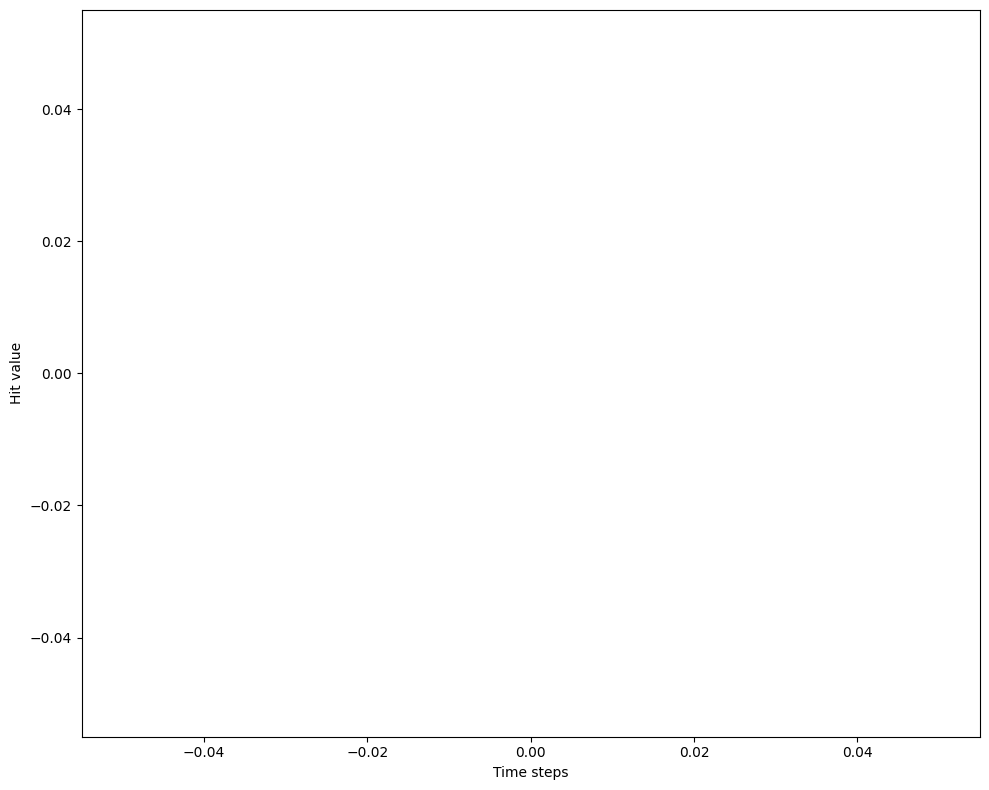

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
# Assuming `data` is your 2D array of shape (time_steps, 4)
data = merged_real_tabs.T  # Dummy data

colors = ['blue', 'orange', 'green', 'red']

for i in range(4):
    # Find where data is not 0
    hits = data[:, i] != 0
    
    ax.plot(np.arange(len(data))[hits], data[hits, i], marker='o', linestyle='', markersize=2, color='orange', label=f'Drum hit {i+1}')

plt.xlabel('Time steps')
plt.ylabel('Hit value')
plt.tight_layout()
plt.show()
